# Parker Dunn
(pgdunn@bu.edu | pdunn91@gmail.com)  
Created on July 1st, 2022


__Assignment for COURSERA: Introduction to Deep Learning (via CU Boulder)__

__Assignment:__ Week 3 - CNN Cancer Detection Kaggle Mini-Project

## Progress...
[Done - 1st draft] Step 1 - Description of the data and problem  
[Done - 1st draft] Step 2 - EDA  
[*in progress*] Step 3 - Model Achitecture

    * Discussed model design decisions
    * Designed and implemented a design testing procedure
    * Most architecture design work happened in this section
    * Varied -> layer design, CNN filter design, etc.
    * Held constant -> learning rate, momentum, etc.
    
[ _ ] Step 4 -  Results and Analysis

    * This section was reserved for hyperparameter tuning

[ _ ] Step 5 -  
[ _ ] Step 6 -  

# Information about the Competition/Data
___

The Kaggle competition is called "Histopathologic Cancer Detection"  
LINK: https://www.kaggle.com/c/histopathologic-cancer-detection

### Data Description (from Kaggle)

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

___
# My work starts here
___

In [1]:
# imports of packages

from helperfunctions import *

# Setup

%matplotlib inline

## Step 1 - Description of the data and problem

For this project, originally a Kaggle competition, the task is to identify images of cells that contain metastatic cancer. This is a binary classification task on images. If an image contains at least one pixel of tumor tissue within a specified region, it is given a positive label. The images are 96x96 pixels, but the specific region used to classify the images is the center 32x32 pixel region. The task is setup this way to enable fully-convolutional models that do not use padding.

The data for this task is provided as 96x96 images, which are small parts of larger images. Reading in the three color channels (RGB) for each pixel,  this means there are 27,648 total features for each image: the three RGB channels for each pixel and 9,216 pixels. Each pixel is provided as three values from 0 to 255, representing the contribution of each RGB color channel.

There are 277,483 images provided for this task. The images are divided into 220,025 images for training, since the corresponding labels are provided, and 57,458 images without provided labels. For these test images, a model will try to correctly predict whether these images have (1) or do not have (0) metastatic cancer cells.

Summary:
* 96x96x3 dimensions for each image -> 27,648 features initially
* 220,025 images in training set
* TRAINING: 27648 features x 220,025 images

### Loading the data

**BELOW** -> Too much data to read all images in at once

In [2]:
# X, X_IDs, X_test, X_test_IDs, Y_df = read_data()

# samples in 'X' and file names in 'X_ids' are in the same order as long as they are not sorted!

Instead, I will read in the data that I can to start.
- Load image labels for trianing data
- Load names of all files

As I need the images, I will have to load them one at a time!

In [3]:
training_images, testing_images, y_train = load_image_info()

y_train.head(8)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1


In [4]:
print("Double checking the type of the 'id' of the images...",
      "\n\n",
      y_train.loc[0,'id'],
      "\n\n",
      type(y_train.loc[0,'id']))

Double checking the type of the 'id' of the images... 

 f38a6374c348f90b587e046aac6079959adf3835 

 <class 'str'>


___

## Step 2 - Exploratory Data Analysis (EDA)

#### Inspecting a single image

id       f38a6374c348f90b587e046aac6079959adf3835
label                                           0
Name: 0, dtype: object
<class 'pandas.core.series.Series'> 




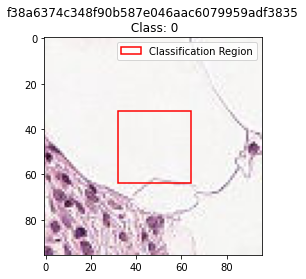

In [5]:
print(y_train.iloc[0,:])
print(type(y_train.iloc[0,:]),"\n\n")

# Function from 'helperfunctions.py'
show_training_image(y_train.iloc[0,:])


#### Inspecting multiple images

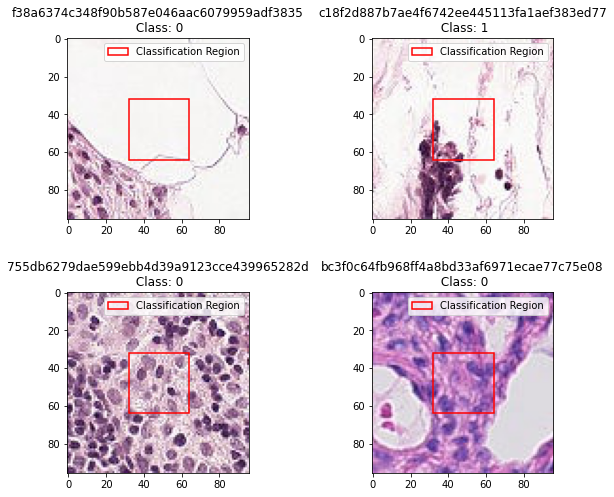

In [6]:
show_training_images(y_train.iloc[0:4,:], (2,2))

#### Examining information distribution of the images

Here, I looked at...
* the "average" picture
* comparison of purple color distributions

In [23]:
%%time

# loop to collect averages of 100 images at a time
# the 100 image avgs are saved in a list
avg_img_100 = []
moving_avg = np.zeros((96,96,3))
counter = 0

for i in range(len(y_train.index)):
    if (i % 100 == 0) and (i != 0):
        moving_avg = moving_avg/100
        avg_img_100.append(moving_avg)
        moving_avg = np.zeros((96,96,3))
        counter = 0
    
    image = load_image_data(y_train.loc[i,"id"])
    counter += 1
    moving_avg = moving_avg + image

if counter > 0:
    print("End value of counter: ",counter)
    avg_img_100.append(moving_avg/counter)

print("Number of NumPy arrays saved in avg_img_100: ", len(avg_img_100))
# print(avg_img_100[0].shape)

# getting the "average image" from the averages of 100 images
avg_img = np.zeros((96,96,3))
for i in range(len(avg_img_100)):
    avg_img = avg_img + avg_img_100[i]

avg_img = avg_img/len(avg_img_100)

savable_avg_img = avg_img.reshape(96*96,3)

np.savetxt("avg_training_image.txt", savable_avg_img, delimiter=",")

print("Shape of 'avg_img': ", avg_img.shape)
print("\nSample values...\n", avg_img[0:2,0:2,:])

End value of counter:  25
Number of NumPy arrays saved in avg_img_100:  2201
Shape of 'avg_img':  (96, 96, 3)

Sample values...
 [[[179.17045888 139.64360745 177.6454975 ]
  [179.20284416 139.58373467 177.68106315]]

 [[179.10551567 139.58219446 177.56161745]
  [179.07598364 139.48654702 177.56427079]]]
CPU times: user 42.5 s, sys: 2.38 s, total: 44.9 s
Wall time: 45.1 s


Text(0.5, 1.0, 'Average training image - Both Classes')

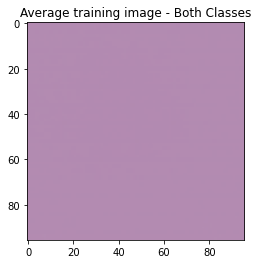

In [24]:
# Displaying the avg image
avg_img_int = avg_img.astype('int')
plt.imshow(avg_img_int)
plt.title("Average training image - Both Classes")

Probably should have figured that the avg of all images would not be particularly helpful.

I am curious to see if there is a difference between the average positive vs. negative image. I will basically repeat the same process once more; hopefully, there is some more useful information there.

In [25]:
%%time

# loop to collect averages of 100 images at a time
# the 100 image avgs are saved in a list
avg_img_pos = []
avg_img_neg = []
moving_avg_pos = np.zeros((96,96,3))
moving_avg_neg = np.zeros((96,96,3))
counter_pos = 0
counter_neg = 0

for i in range(len(y_train.index)):
    if (counter_pos == 1000):
        moving_avg_pos = moving_avg_pos/counter_pos
        avg_img_pos.append(moving_avg_pos)
        moving_avg_pos = np.zeros((96,96,3))
        counter_pos = 0
    
    if (counter_neg == 1000):
        moving_avg_neg = moving_avg_neg/counter_neg
        avg_img_neg.append(moving_avg_neg)
        moving_avg_neg = np.zeros((96,96,3))
        counter_neg = 0
    
    image = load_image_data(y_train.loc[i,"id"])
    
    if (y_train.loc[i,"label"] == 1):
        counter_pos += 1
        moving_avg_pos = moving_avg_pos + image
    else:
        counter_neg += 1
        moving_avg_neg = moving_avg_neg + image

if (counter_pos > 0):
    avg_img_pos.append(moving_avg_pos/counter_pos)
if (counter_neg > 0):
    avg_img_neg.append(moving_avg_neg/counter_neg)

avg_pos = np.zeros((96,96,3))
avg_neg = np.zeros((96,96,3))

# POSITIVE IMAGES
for i in range(len(avg_img_pos)):
    avg_pos = avg_pos + avg_img_pos[i]
avg_pos = avg_pos/len(avg_img_pos)

# NEGATIVE IMAGES
for j in range(len(avg_img_neg)):
    avg_neg = avg_neg + avg_img_neg[i]
avg_neg = avg_neg/len(avg_img_neg)

CPU times: user 44.8 s, sys: 2.48 s, total: 47.3 s
Wall time: 47.5 s


Text(0.5, 1.0, 'Avg Negative Image')

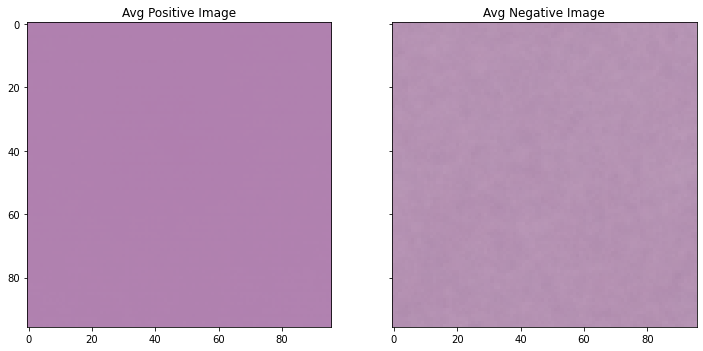

In [31]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,10), sharey=True)

avg_pos_int = avg_pos.astype('int')
avg_neg_int = avg_neg.astype('int')

axes[0].imshow(avg_pos_int)
axes[0].set_title("Avg Positive Image")
axes[1].imshow(avg_neg_int)
axes[1].set_title("Avg Negative Image")

There isn't much to take away from these images. Since they are averages over many images, they look mostly uniform.


There is a slight difference in the overall color and presentation of cell shapes in the images. The shade of purple of the average negative images appears to be slightly darker and more transparent. The average negative image also apperas to have some darker spots that are faintly identfiable.

The unhealthy cancer cells lose their distinct oval/circular shape. The distinction between the two images does suggest that the distince shape of the healthy cells is a fundamental feature of the images that can help me distiguish between the two classes of images.

__Clearly, purple is the dominant color of these images (due to the staining process used for visualization). NEXT, I will compare how the component colors of purpose (red and blue) compare between the positive and negative images.__


In [ ]:
%%time